In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock

mpdistrict  = np.loadtxt('data/mpdistrict.dat', skiprows = 2, delimiter =',', dtype = float)
mpparty = np.loadtxt('data/mpparty.dat', skiprows = 3, delimiter =',', dtype = float)
votes = np.loadtxt('data/votes.dat', delimiter = ',', dtype = float)
mpsex  = np.loadtxt('data/mpsex.dat', skiprows = 2, delimiter =',', dtype = float)
mpnames = np.loadtxt('data/mpnames.txt', delimiter ='\n', dtype = str)

votes = np.reshape(votes,(349,31))
votes_labels = list(range(len(votes)))

partynames = ['no party', 'm', 'fp', 's', 'v', 'mp', 'kd', 'c']

In [84]:
# Let's have a look at the data

print(votes)

print("Party")
print((mpparty[0:5]))

print("Sex")
print((mpsex[0:5]))

print("District")
print((mpdistrict[0:5]))

[[ 0.   1.   0.  ...,  0.5  0.   1. ]
 [ 0.   1.   1.  ...,  0.   0.5  0. ]
 [ 0.   1.   0.  ...,  0.5  0.   1. ]
 ..., 
 [ 1.   1.   1.  ...,  1.   1.   0.5]
 [ 0.   1.   0.  ...,  0.5  0.5  0.5]
 [ 0.   1.   1.  ...,  0.   0.5  0. ]]
Party
[ 1.  2.  1.  1.  3.]
Sex
[ 0.  0.  0.  0.  1.]
District
[ 1.  1.  1.  1.  1.]


In [87]:
class SOM():
    def __init__(self):
        self.weights = np.random.rand(100, 31)
        self.nsize = 15 # does not longer denote neighbourhood size in neighbours but spatial distance boundary. 20 is the distance from 0,0 --> 10, 10. 
        
    def distance(self, data, weight):
        distance = data - weight
        
        # distances is the length of the distance vector!
        return np.dot(distance.T, distance)

    def get_winner(self, inp):
        
        min_dist = self.distance(self.weights[0,:], inp)
        winner = 0
        
        for i in range(self.weights.shape[0]):
            dist = self.distance(self.weights[i,:], inp)
            if dist < min_dist:
                min_dist = dist
                winner = i
                
        return winner
    
    def get_neighbours(self, winner):
        # returns the neighbourhood around the winner
        neighbours = []
        i = 1
        
        maxneighbour = self.weights.shape[0]

        #while (len(neighbours) < self.nsize):
        #    if (winner - i >= 0):
        #        neighbours.append(winner - i)
        #    if (winner + i < maxneighbour):
        #        neighbours.append(winner + i)
        #    i += 1
        
        winner_cords = np.array([np.floor(winner/10), winner % 10])
        neighbours = []

        for i in range(100):
            i_cords = np.array([np.floor(i/10), i % 10])
            if cityblock(winner_cords, i_cords) <= self.nsize: # check spatial distance
                neighbours.append(i)
                
        return neighbours

    def update_weights(self, neighbours, sample, lr = 0.1):
        # Update weights of all neighbours to become slightly more similar to the input pattern (sample)
        for i in neighbours:
            weight = self.weights[i,:].copy()
            self.weights[i, :] = np.add(weight, lr * np.subtract(sample, weight))
    
    def train(self, data, epochs = 50):
        for epoch in range(epochs):
            for i in range(data.shape[0]):
                # For each <mp> you will have to pick out the corresponding row from the props matrix.
                # Then find the row of the weight matrix with the shortest distance to this attribute vector
                # aka the winner
                sample = data[i,:].copy()
                winner = self.get_winner(sample)
                
                # Once you have the index to the winning node, it is time to update the weights.
                neighbours = self.get_neighbours(winner)
                
                self.update_weights(neighbours, sample)
                        
            # Update neighbourhood size
            if (epoch % 10 == 9):
                if self.nsize > 10:
                    self.nsize -= 2
                elif self.nsize > 2:
                    self.nsize -= 1

            if epoch % 10==0:
                print("Epoch {}. Neighbourhood radius {}".format(epoch, self.nsize))

    def predict(self, data, names):
        output = []
        for i in range(data.shape[0]):
            sample = data[i,:].copy()
            winner = self.get_winner(sample)
            output.append([winner, names[i]])
        output = np.array(output, dtype=object)
        
        # sort by index
        sort_idx = output[:,0].argsort()
                
        return output

In [88]:
model = SOM()
model.train(votes, 100)
pred = model.predict(votes, votes_labels)

Epoch 0. Neighbourhood radius 15
Epoch 10. Neighbourhood radius 13
Epoch 20. Neighbourhood radius 11
Epoch 30. Neighbourhood radius 9
Epoch 40. Neighbourhood radius 8
Epoch 50. Neighbourhood radius 7
Epoch 60. Neighbourhood radius 6
Epoch 70. Neighbourhood radius 5
Epoch 80. Neighbourhood radius 4
Epoch 90. Neighbourhood radius 3


In [114]:

unique, counts = np.unique(mp_cord, return_counts=True, axis = 0)
counts = counts.reshape(unique.shape[0],1)
counts_data = np.column_stack((unique,counts))

In [115]:


names = pd.DataFrame(mpnames).rename(columns={0:'names'}).reindex(pred[:,1]).reset_index().rename(columns={'index':'id'})


sex = pd.DataFrame(mpsex).rename(columns={0:'sex'}).reindex(pred[:,1]).reset_index().rename(columns={'index':'id'})


district = pd.DataFrame(mpdistrict).rename(columns={0:'district'}).reindex(pred[:,1]).reset_index().rename(columns={'index':'id'})


counts = pd.DataFrame(counts_data).rename(columns={0:'x',1:'y',2:'count'})


party = pd.DataFrame(mpparty).rename(columns={0:'party'}).reindex(pred[:,1]).reset_index().rename(columns={'index':'id'})




In [116]:
# we need to map each sample (mp) to x and y coordinates in an 10 x 10 grid
mp_cord = np.empty((349,2))
for i, sample in enumerate(pred[:,0]):
    mp_cord[i, 0] = np.floor(sample / 10) # x-coordinates
    mp_cord[i, 1] = sample % 10 # y-coordinates

    

mp_map = (pd.DataFrame(mp_cord)
          .rename(columns={0:'x',1:'y'}))
mp_map['output'] = pred[:,0]
mp_map['id'] = pred[:,1]


mp_map = (mp_map.merge(names, how ='left', on='id')
            .merge(sex, how = 'left', on ='id')
            .merge(district, how ='left', on = 'id')
            .merge(party, how ='left', on='id')
            .merge(counts, on =['x','y'], how = 'left'))

In [117]:
mp_map.head(20)

,x,y,output,id,names,sex,district,party,count
0,8.0,0.0,80,0,Skarman Carl-Erik,0.0,1.0,1.0,47.0
1,0.0,1.0,1,1,Romanus Gabriel,0.0,1.0,2.0,29.0
2,8.0,0.0,80,2,Odenberg Mikael,0.0,1.0,1.0,47.0
3,8.0,0.0,80,3,Jarrel Henrik S,0.0,1.0,1.0,47.0
4,9.0,9.0,99,4,Lindgren Sylvia,1.0,1.0,3.0,108.0
5,8.0,0.0,80,5,Ask Beatrice,1.0,1.0,1.0,47.0
6,0.0,7.0,7,6,Hoffmann Ulla,1.0,1.0,4.0,21.0
7,9.0,9.0,99,7,Nordlander Inger,1.0,1.0,3.0,108.0
8,3.0,9.0,39,8,Ruwaida Yvonne,1.0,1.0,5.0,3.0
9,0.0,1.0,1,9,Konberg Bo,0.0,1.0,2.0,29.0


In [118]:
def rand_color():
    import random
    r = lambda: random.randint(0,255)
    return('#%02X%02X%02X' % (r(),r(),r()))

Sex


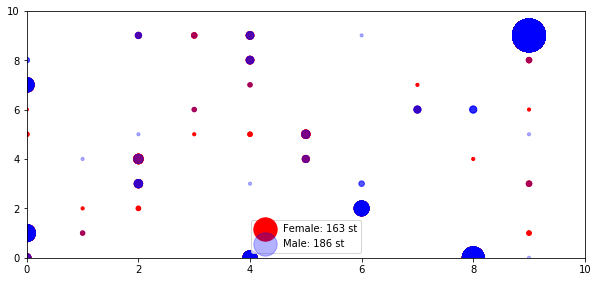

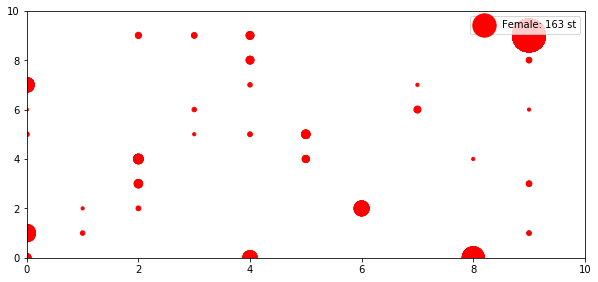

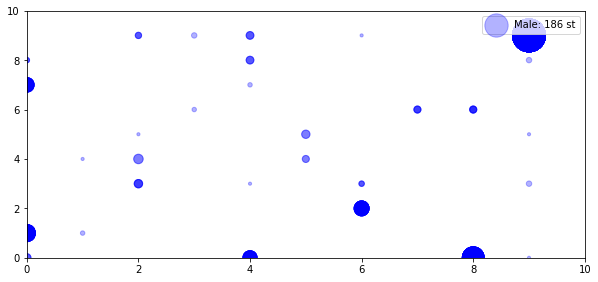

In [122]:
## Sex
print("Sex")
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)

male = mp_map[mp_map.sex == 0] # male
female = mp_map[mp_map.sex == 1] # female
plt.scatter(female['x'], female['y'], s=female['count']*10, c='red', alpha = 1, label = "Female: {} st".format(female.shape[0]))
plt.scatter(male['x'], male['y'], s=male['count']*10, c='blue', alpha = 0.3, label = "Male: {} st".format(male.shape[0]))

ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)
plt.scatter(female['x'], female['y'], s=female['count']*10, c='red', alpha = 1, label = "Female: {} st".format(female.shape[0]))

ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.legend()
plt.show()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)

plt.scatter(male['x'], male['y'], s=male['count']*10, c='blue', alpha = 0.3, label = "Male: {} st".format(male.shape[0]))

ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.legend()
plt.show()


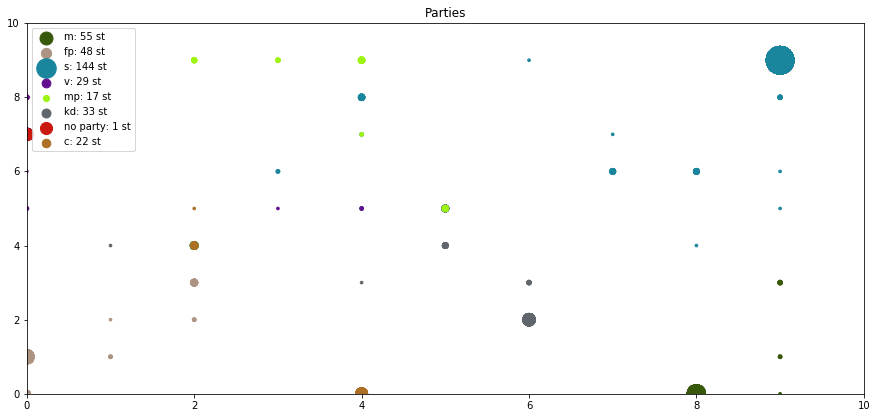

In [130]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(211)


for party in mp_map['party'].unique():
    df = mp_map[mp_map.party == party]
    name = partynames[int(party)]
    plt.scatter(df['x'], df['y'], s=df['count']*7, c=rand_color(), label = name + ": {} st".format(df.shape[0]))
    ax = plt.gca()
ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.legend()
plt.title("Parties")
plt.show()

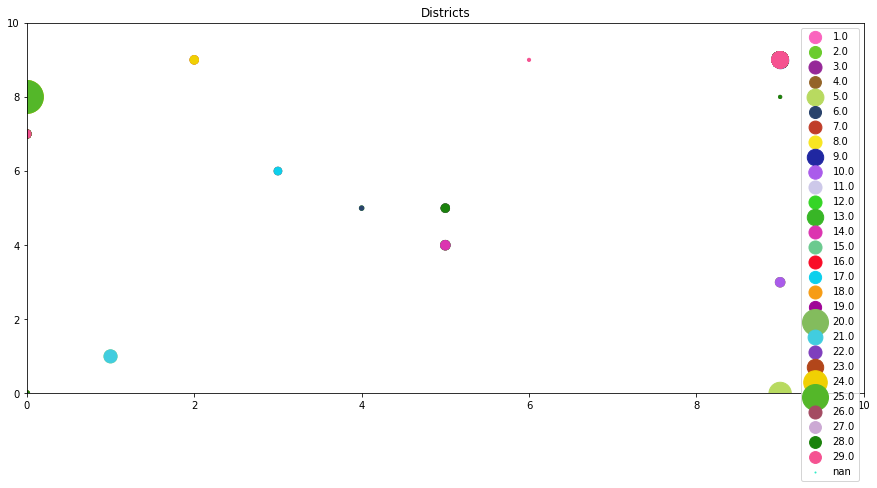

In [103]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(211)


for district in mp_map['district'].unique():
    df = mp_map[mp_map.district == district]
    plt.scatter(df['x'], df['y'], s=df['count']*10, c=rand_color(), label = district)
    ax = plt.gca()
ax.set_xlim([0,10])
ax.set_ylim([0,10])
ax.legend()
plt.title("Districts")
plt.show()